,CasosDia,Temp. Ins. (C),Umi. Ins. (%),Chuva (mm),CasosDiasTarget
Data,,,,,
2020-03-22,3,26.616667,42.500000,4.453936,4
2020-03-23,3,26.462500,52.833333,4.453936,2
2020-03-24,3,24.812500,64.541667,8.800000,2
2020-03-25,1,22.008333,82.000000,28.800000,2
2020-03-26,0,21.225000,83.666667,0.200000,3
...,...,...,...,...,...
2023-12-27,8,22.787500,80.750000,4.453936,3
2023-12-28,4,24.291667,70.416667,4.453936,6
2023-12-29,7,25.687500,69.083333,4.453936,6


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1380 entries, 2020-03-22 to 2023-12-31
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CasosDia         1380 non-null   int64  
 1   Temp. Ins. (C)   1380 non-null   float64
 2   Umi. Ins. (%)    1380 non-null   float64
 3   Chuva (mm)       1380 non-null   float64
 4   CasosDiasTarget  1380 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 64.7 KB


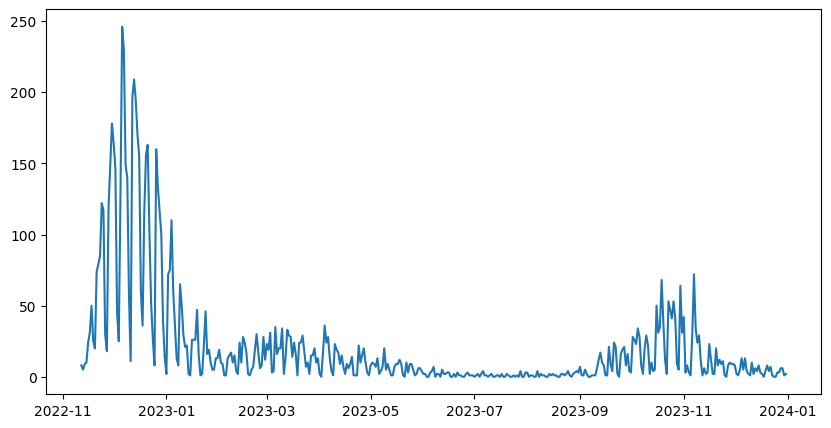

In [1]:
##IMPORTANDO

#from google.colab import drive
#drive.mount('/content/drive')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statistics
from scipy.stats import mannwhitneyu
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR 
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from scipy.stats import mannwhitneyu
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

# Evitar avisos
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv("planilhas/dfDias7desloc.csv", sep=';', parse_dates=['Data'], index_col="Data")
display(df)
df.info()

split = int(0.7 * len(df))
treino = df[:split]
teste = df[split:]


x_treino = treino.drop(columns='CasosDiasTarget')
y_treino = treino['CasosDiasTarget']

x_teste = teste.drop(columns='CasosDiasTarget')
y_teste = teste['CasosDiasTarget']

# Plotar as previsões em relação aos valores reais

plt.figure(figsize=(10, 5))
plt.plot(y_teste)



# XGBoost


In [58]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

param_grid = {'booster': ['gblinear'], 'n_estimators': [100, 200, 500, 1000]}

melhor_validacao_XG = float('inf')  # Inicialize com um valor muito alto
best_paramsXG = {}

for booster in param_grid['booster']:
    for estimators in param_grid['n_estimators']:
        XG = XGBRegressor(booster=booster, n_estimators=estimators)
        XG.fit(x_treino, y_treino)
        opiniao = XG.predict(x_treino)
        mse_validacao_XG = mean_squared_error(y_treino, opiniao)
        
        if mse_validacao_XG < melhor_validacao_XG:
            melhor_validacao_XG = mse_validacao_XG
            best_paramsXG = {
                'booster': booster,
                'n_estimators': estimators
            }

print("Melhor MSE de validação:", melhor_validacao_XG)
print("Melhores hiperparâmetros:", best_paramsXG)

# Agora, treine o modelo usando os melhores hiperparâmetros encontrados
XG = XGBRegressor(booster=best_paramsXG['booster'], n_estimators=best_paramsXG['n_estimators'])
XG.fit(x_treino, y_treino)

# Faça previsões com o modelo treinado
opiniao_XG = XG.predict(x_teste)

# Calcule as métricas de avaliação
mae = mean_absolute_error(y_teste, opiniao_XG).round(2)
mse = mean_squared_error(y_teste, opiniao_XG).round(2)
rmse = np.sqrt(mse).round(2)



Melhor MSE de validação: 3076.3283860217875
Melhores hiperparâmetros: {'booster': 'gblinear', 'n_estimators': 1000}


In [59]:
# RESULTADOS !!!!
dfXG = pd.DataFrame({
    'booster':best_paramsXG['booster'],
    'estimators':best_paramsXG['n_estimators'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse]
})


print("O ÚLTIMO VALOR (20) É A MÉDIA !!!")

display(dfXG)
dfXG.to_csv('resultadosModelos/dfXG.csv', sep = ';', index = False, encoding='UTF-8')

O ÚLTIMO VALOR (20) É A MÉDIA !!!


,booster,estimators,MAE,MSE,RMSE
0,gblinear,1000,14.42,428.85,20.71


In [60]:
import joblib


joblib.dump(opiniao_XG, 'predsSalva/xgboost.pkl')

['predsSalva/xgboost.pkl']

# CHEKPOINT

In [3]:
import joblib

opiniao_XG = joblib.load('predsSalva/xgboost.pkl')

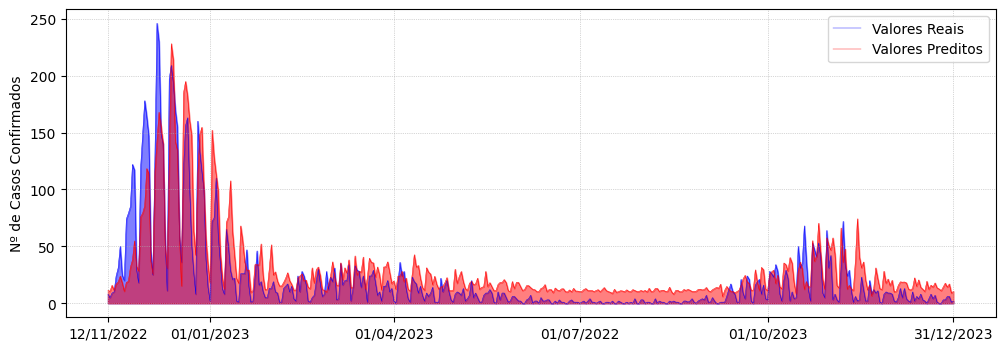

Numero de casos reais:  8737
Numero de casos predito:  11961


In [4]:
len(opiniao_XG)


serie_XG = pd.Series(opiniao_XG, index=x_teste.index)
aux=serie_XG
serie = pd.Series(aux, index=x_teste.index)

stringGraf = 'graficos/4-'+ 'XGboost' + '.pdf'
plt.figure(figsize=(12, 4))
plt.plot(y_teste, label='Valores Reais', color='blue', linewidth=0.3)
plt.plot(serie, label='Valores Preditos', color='red', linewidth=0.3)
plt.fill_between(x_teste.index, y_teste, color='blue', alpha=0.5)
plt.fill_between(x_teste.index, serie, color='red', alpha=0.5)  # Pinta a área entre as linhas
plt.ylabel('Nº de Casos Confirmados')
plt.legend()
ticks_pos = [df[split:].index[0], '2023-01','2023-04', '2023-07','2023-10', df[split:].index[-1]]
ticks_labels = [
    '12/11/2022',
    '01/01/2023',
    '01/04/2023',
    '01/07/2022',
    '01/10/2023',
    '31/12/2023',
]
plt.grid(linestyle=':', linewidth=.5, alpha=1)
plt.xticks(ticks_pos, labels=ticks_labels)
plt.savefig(stringGraf, dpi=300, bbox_inches="tight")
plt.show()



n_pred = int(aux.sum())
print('Numero de casos reais: ', y_teste.sum())
print('Numero de casos predito: ', n_pred)